In [1]:
# This is needed to import the CC and EC Models from this location in this project.
import sys
sys.path.append("../")

from MagneticFluxRopeModels.MFRBaseModel import MFRBaseModel
from MagneticFluxRopeModels.ECModel import ECModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import seaborn as sns

from MagneticFluxRopeModels.MFRMetaModel import label_mapping, set_axis_grid_style

In [2]:
def perturb_error(model_type: MFRBaseModel, parameter_1_name: str, parameter_2_name: str, df: pd.DataFrame, model_parameters_opt, crossing_parameters_opt, f_opt: float, residue_method: str, epsilon: float = 1e-3) -> float:
    # Ensure that epsilon is positive
    epsilon = abs(epsilon)

    if parameter_1_name == parameter_2_name:
        model_parameters_plus, crossing_parameters_plus = add_epsilon(model_parameters_opt, crossing_parameters_opt, parameter_1_name, epsilon)
        f_plus, *_ = MFRBaseModel.evaluate_model_and_crossing(model_type, df, residue_method, model_parameters_plus, crossing_parameters_plus)

        model_parameters_minus, crossing_parameters_minus = add_epsilon(model_parameters_opt, crossing_parameters_opt, parameter_1_name, -epsilon)
        f_minus, *_ = MFRBaseModel.evaluate_model_and_crossing(model_type, df, residue_method, model_parameters_minus, crossing_parameters_minus)

        second_derivative = (f_plus - 2*f_opt + f_minus) / (epsilon)**2
        return second_derivative
    else:
        # f(x0 + ei + ej)
        model_parameters_pp, crossing_parameters_pp = add_epsilon(model_parameters_opt, crossing_parameters_opt, parameter_1_name, epsilon)
        model_parameters_pp, crossing_parameters_pp = add_epsilon(model_parameters_pp, crossing_parameters_pp, parameter_2_name, epsilon)
        f_pp, *_ = MFRBaseModel.evaluate_model_and_crossing(model_type, df, residue_method, model_parameters_pp, crossing_parameters_pp)

        # f(x0 + ei - ej)
        model_parameters_pm, crossing_parameters_pm = add_epsilon(model_parameters_opt, crossing_parameters_opt, parameter_1_name, epsilon)
        model_parameters_pm, crossing_parameters_pm = add_epsilon(model_parameters_pm, crossing_parameters_pm, parameter_2_name, -epsilon)
        f_pm, *_ = MFRBaseModel.evaluate_model_and_crossing(model_type, df, residue_method, model_parameters_pm, crossing_parameters_pm)

        # f(x0 - ei + ej)
        model_parameters_mp, crossing_parameters_mp = add_epsilon(model_parameters_opt, crossing_parameters_opt, parameter_1_name, -epsilon)
        model_parameters_mp, crossing_parameters_mp = add_epsilon(model_parameters_mp, crossing_parameters_mp, parameter_2_name, epsilon)
        f_mp, *_ = MFRBaseModel.evaluate_model_and_crossing(model_type, df, residue_method, model_parameters_mp, crossing_parameters_mp)

        # f(x0 - ei - ej)
        model_parameters_mm, crossing_parameters_mm = add_epsilon(model_parameters_opt, crossing_parameters_opt, parameter_1_name, -epsilon)
        model_parameters_mm, crossing_parameters_mm = add_epsilon(model_parameters_mm, crossing_parameters_mm, parameter_2_name, -epsilon)
        f_mm, *_ = MFRBaseModel.evaluate_model_and_crossing(model_type, df, residue_method, model_parameters_mm, crossing_parameters_mm)

        second_derivative = (f_pp - f_pm - f_mp + f_mm) / (4 * epsilon**2)
        return second_derivative

def add_epsilon(model_parameters_opt, crossing_parameters_opt, parameter_name, epsilon: float):
    model_parameters_plus = model_parameters_opt.copy()
    crossing_parameters_plus = crossing_parameters_opt.copy()

    if parameter_name in model_parameters_plus:
        model_parameters_plus[parameter_name] += epsilon
    elif parameter_name in crossing_parameters_plus:
        crossing_parameters_plus[parameter_name] += epsilon
    else:
        raise ValueError(f"Parameter {parameter_name} not found in model or crossing parameters.")

    return model_parameters_plus, crossing_parameters_plus

In [3]:
B_z_0 = 10
ec_model = ECModel(delta=0.7, psi=math.radians(30), B_z_0=B_z_0)
y_0 = 0.3
num_time_points = 17
residue_method = "SSE"

model_params = {
    "delta": {"mode": "optimised", "initial_value": 0.7, "bounds": [0.35, 1]},
    "psi": {"mode": "optimised", "initial_value": math.radians(30), "bounds": [1e-3, math.pi - 1e-3]},
    "tau": {"mode": "optimised", "initial_value": 1.3, "bounds": [0.3, 2.0]},
    "C_nm": {"mode": "optimised", "initial_value": 1, "bounds": [0.3, 3.0]},
    "B_z_0": {"mode": "optimised", "initial_value": 10.0, "bounds": [5, 15]},
}

crossing_params = {
    "y_0": {"mode": "optimised", "initial_value": 0.3, "bounds": [-0.65, 0.65]},
    "v_sc": {"mode": "fixed", "value": 450.0},
}

results = []

for sigma in [0.05]:#np.linspace(0.01, 0.1, 5):
    print("Simulating with noise level:", sigma)
    
    this_results = {"sigma": sigma}
    df_noisy = ec_model.simulate_crossing(y_0=y_0, v_sc=450, noise_type="gaussian", epsilon=sigma*B_z_0, random_seed=1, time_stencil=num_time_points)
    
    fitted_model, fitted_model_parameters, fitted_crossing_parameters, df_fitted, info = ECModel.fit(ECModel, df_noisy, model_params, crossing_params, residue_method=residue_method)
    this_results["fitted_model"] = fitted_model
    this_results["fitted_model_parameters"] = fitted_model_parameters
    this_results["fitted_crossing_parameters"] = fitted_crossing_parameters
    this_results["df_fitted"] = df_fitted
    this_results["f_opt"] = info["f_opt"]
    
    model_parameters_opt = info["model_parameters_opt"]
    crossing_parameters_opt = info["crossing_parameters_opt"]
    all_opt_param_names = set(model_parameters_opt.keys()) | set(crossing_parameters_opt.keys())
    # design_variables = list(all_opt_param_names)
    design_variables = ["y_0", "B_z_0", "tau", "C_nm", "delta", "psi"]
    this_results["design_variables"] = design_variables

    # Compute the Hessian matrix
    n = len(all_opt_param_names)
    hessian = np.zeros((n, n))

    for i, param_name_i in enumerate(design_variables):
        print(param_name_i)
        for j, param_name_j in enumerate(design_variables):
            if i > j:
                continue
            print(i, j, param_name_i, param_name_j)
            hessian[i, j] = perturb_error(ECModel, param_name_i, param_name_j, df_noisy, fitted_model_parameters, fitted_crossing_parameters, f_opt=info["f_opt"], residue_method=residue_method, epsilon=1e-2)
            hessian[j, i] = hessian[i, j]  # Symmetric matrix
    
    this_results["hessian"] = hessian
    # second_derivatives = dict()
    # for param_name in all_opt_param_names:
    #     second_derivative = perturb_error(ECModel, param_name, df_noisy, fitted_model_parameters, fitted_crossing_parameters, f_opt=info["f_opt"], epsilon=1e-3)
    #     second_derivatives[param_name] = second_derivative
    #     print(param_name,":", second_derivative)
    
    # this_results["second_derivatives"] = second_derivatives

    # param_confidences = dict()
    # estimated_error = sigma*ec_model.B_z_0
    # for param_name in all_opt_param_names:
    #     param_confidences[param_name] = math.sqrt((2*estimated_error) / second_derivatives[param_name])
    # this_results["param_confidences"] = param_confidences
    
    # Compute the actual errors in the optimised parameters
    actual_errors = dict()
    for param_name in all_opt_param_names:
        if param_name in model_parameters_opt:
            actual_errors[param_name] = model_parameters_opt[param_name] - getattr(ec_model, param_name)
        else:
            actual_errors[param_name] = crossing_parameters_opt[param_name] - y_0
    this_results["actual_errors"] = actual_errors
        
    results.append(this_results)

Simulating with noise level: 0.05
y_0
0 0 y_0 y_0
0 1 y_0 B_z_0
0 2 y_0 tau
0 3 y_0 C_nm
0 4 y_0 delta
0 5 y_0 psi
B_z_0
1 1 B_z_0 B_z_0
1 2 B_z_0 tau
1 3 B_z_0 C_nm
1 4 B_z_0 delta
1 5 B_z_0 psi
tau
2 2 tau tau
2 3 tau C_nm
2 4 tau delta
2 5 tau psi
C_nm
3 3 C_nm C_nm
3 4 C_nm delta
3 5 C_nm psi
delta
4 4 delta delta
4 5 delta psi
psi
5 5 psi psi


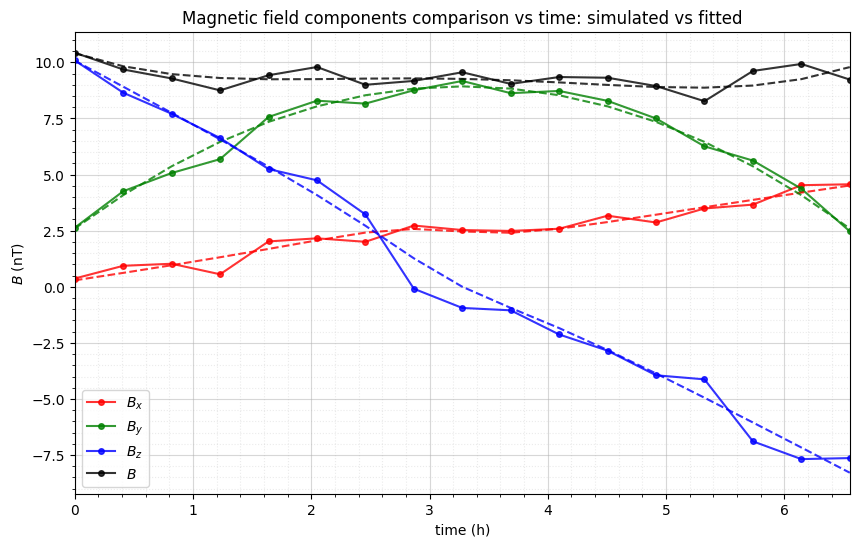

In [5]:
ec_model.plot_crossing_magnetic_difference(df_noisy, df_fitted, save_filename="simulated_vs_fitted.png")

In [6]:
print(results[0]["fitted_model_parameters"])
print(math.degrees(results[0]["fitted_model_parameters"]["psi"]))

{'delta': np.float64(0.6395167308963584), 'psi': np.float64(0.4453641936078571), 'tau': np.float64(1.3540392984203418), 'C_nm': np.float64(1.0175383145650203), 'B_z_0': np.float64(9.93697280218865)}
25.51748863997749


In [7]:
results[0]["fitted_crossing_parameters"]

{'y_0': np.float64(0.3495099627496005),
 'v_sc': 450.0,
 'time_stencil': array([    0.        ,  1474.57780632,  2949.15561264,  4423.73341897,
         5898.31122529,  7372.88903161,  8847.46683793, 10322.04464425,
        11796.62245057, 13271.2002569 , 14745.77806322, 16220.35586954,
        17694.93367586, 19169.51148218, 20644.08928851, 22118.66709483,
        23593.24490115])}

In [8]:
results[0]["f_opt"] / num_time_points

np.float64(0.49630758402259234)

In [9]:
H = results[0]["hessian"]
H_inv = np.linalg.inv(H)
design_variables = results[0]["design_variables"]
design_variables

['y_0', 'B_z_0', 'tau', 'C_nm', 'delta', 'psi']

In [10]:
mse = results[0]["f_opt"]
sse = mse# * num_time_points
dof = 3*num_time_points - len(design_variables)
print("dof: ", dof)
sigma_squared = sse / dof
sigma_squared

dof:  45


np.float64(0.18749397618631264)

In [11]:
from scipy.stats import t

alpha = 0.05 # Confidence of 95%

# Two-sided critical value
t_crit = t.ppf(1 - alpha/2, df=dof)
print(f"Critical t-value: {t_crit:.3f}")

covariance_matrix = sigma_squared * H_inv
confidence_intervals = t_crit*np.sqrt(np.diag(covariance_matrix))

print("Confidence intervals for the parameters:")
for i, param_name in enumerate(design_variables):
    if param_name == "psi":
        this_confidence_interval = math.degrees(confidence_intervals[i])
    else:
        this_confidence_interval = confidence_intervals[i]
    print(f"{param_name}: {this_confidence_interval:.5f}")

# Actual errors
actual_error = results[0]["actual_errors"]
print("Actual errors for the parameters:")
for i, param_name in enumerate(design_variables):
    if param_name == "psi":
        this_error = math.degrees(actual_error[param_name])
    else:
        this_error = actual_error[param_name]
    print(f"{param_name}: {this_error:.5f}")

Critical t-value: 2.014
Confidence intervals for the parameters:
y_0: 0.06944
B_z_0: 0.50440
tau: 0.06957
C_nm: 0.15514
delta: 0.11130
psi: 8.37979
Actual errors for the parameters:
y_0: 0.04951
B_z_0: -0.06303
tau: 0.05404
C_nm: 0.01754
delta: -0.06048
psi: -4.48251


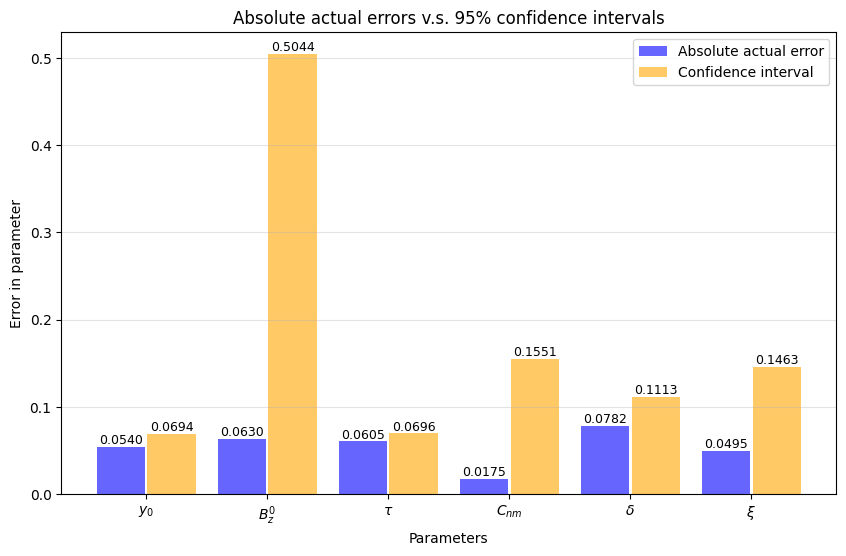

In [15]:
x_ticks = np.arange(len(design_variables))
bar_width = 0.4
eps = 0.01

fig, ax = plt.subplots(figsize=(10, 6))
abs_errors = np.abs(list(actual_error.values()))
b1 = ax.bar(x_ticks - bar_width/2 - eps, abs_errors, width=bar_width, label="Absolute actual error", color="blue", alpha=0.6)
b2 = ax.bar(x_ticks + bar_width/2 + eps, confidence_intervals, width=bar_width, label="Confidence interval", color="orange", alpha=0.6)

bars = b1 + b2
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.4f}", ha="center", va="bottom", fontsize=9)
    
ax.set_xticks(x_ticks)
labels = [label_mapping.get(param, param) for param in design_variables]
labels[-1] = r"$\xi$"
ax.set_xticklabels(labels)
ax.set_xlabel("Parameters")
ax.set_ylabel("Error in parameter")
ax.legend()
ax.grid(alpha=0.35, axis="y")
ax.set_title(r"Absolute actual errors v.s. 95% confidence intervals")
fig.savefig("confidence_intervals_vs_actual_errors.png", dpi=120, bbox_inches="tight")
plt.show()

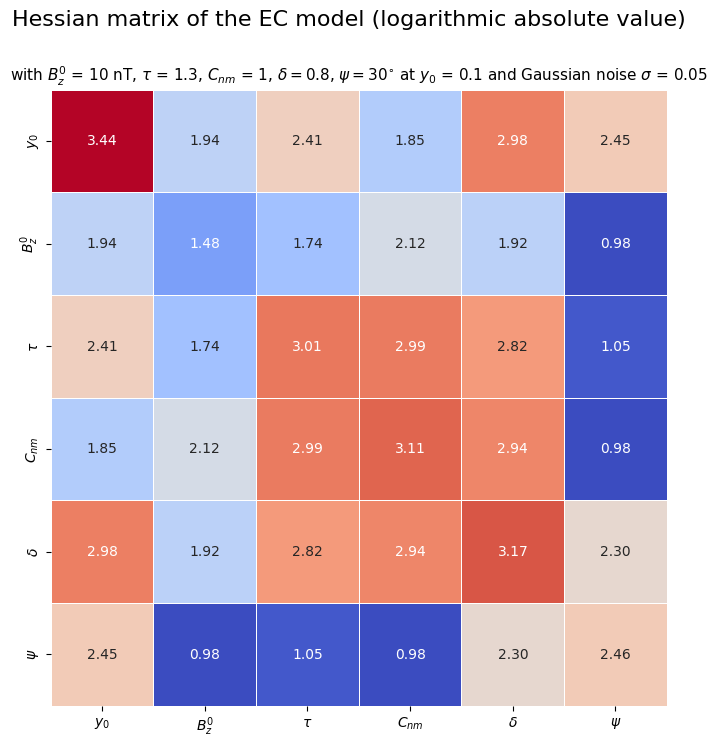

In [16]:
log_abs_hessian = np.log10(np.abs(H))
design_variable_labels = [label_mapping[d] for d in design_variables]

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(log_abs_hessian, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": 1.5}, square=True, linewidths=0.5, cbar=False, ax=ax)
ax.set_xticks(np.arange(len(design_variables)) + 0.5)
ax.set_xticklabels(design_variable_labels)
ax.set_yticks(np.arange(len(design_variables)) + 0.5)
ax.set_yticklabels(design_variable_labels)
fig.suptitle("Hessian matrix of the EC model (logarithmic absolute value)", fontsize=16)
ax.set_title(r"with $B_z^0$ = 10 nT, $\tau$ = 1.3, $C_{nm}$ = 1, $\delta=0.8$, $\psi = 30^{\circ}$ at $y_0$ = 0.1 and Gaussian noise $\sigma$ = 0.05", fontsize=11)
fig.savefig("hessian_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

<>:41: SyntaxWarning: invalid escape sequence '\l'
<>:41: SyntaxWarning: invalid escape sequence '\l'
/var/folders/q2/zrh3sz712dbc665prw9v99q80000gn/T/ipykernel_52489/1297136450.py:41: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel("Eigenvalue ($\lambda$)")


Eigenvalues (curvature): [2.52203535e+00 5.33511225e+01 1.79229826e+02 5.67378166e+02
 2.67983666e+03 3.41327543e+03]
Axes lengths: [0.28160439 0.06122703 0.03340488 0.01877495 0.00863895 0.00765472]
Principal directions (columns):
 [[ 0.10882224 -0.25913636  0.06147643 -0.21691278  0.57560791 -0.73406478]
 [ 0.9155208   0.31261636  0.23846287  0.06402653  0.02803782  0.04840066]
 [-0.07387612 -0.21481634  0.74325987 -0.2791756  -0.52614939 -0.20295031]
 [ 0.2691936  -0.14881733 -0.62194636 -0.32960637 -0.56344748 -0.30406827]
 [-0.16864028  0.47712514  0.0078779   0.59502442 -0.25608012 -0.56940223]
 [-0.20884675  0.73428762  0.00644517 -0.63891784  0.08947705 -0.03067634]]


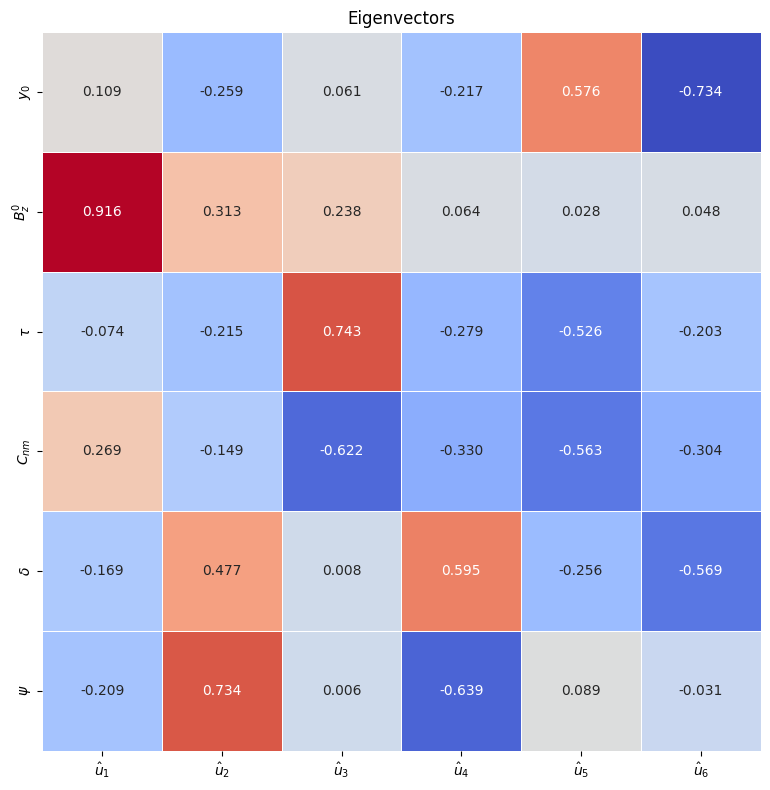

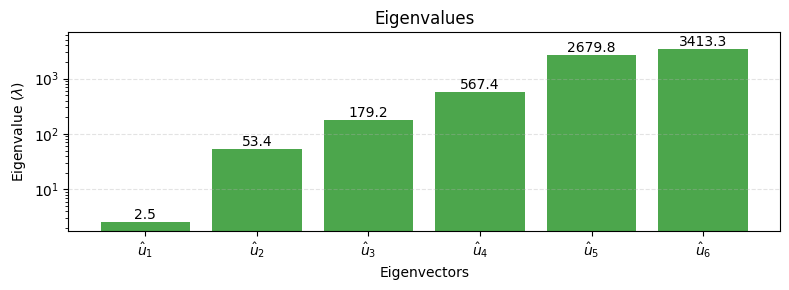

In [17]:
# Eigendecomposition
eigenvalues, eigenvectors = np.linalg.eigh(H)  # Use eigh for symmetric matrices

# Compute semi-axis lengths
epsilon = 0.1
axes_lengths = np.sqrt(2 * epsilon / eigenvalues)

# Print results
print("Eigenvalues (curvature):", eigenvalues)
print("Axes lengths:", axes_lengths)
print("Principal directions (columns):\n", eigenvectors)

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
sns.heatmap(eigenvectors, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={"shrink": 1.5}, square=True, linewidths=0.5, cbar=False, ax=ax)
ax.set_xticks(np.arange(len(design_variables)) + 0.5)
ax.set_xticklabels([r"$\hat{" + "u}_{" + f"{i}" + "}$" for i in range(1, len(design_variables) + 1)])
ax.set_yticks(np.arange(len(design_variables)) + 0.5)
ax.set_yticklabels(design_variable_labels)
ax.set_title("Eigenvectors")
fig.savefig("eigenvectors.png", dpi=150)#, bbox_inches="tight")
plt.show()

# Bar plot of eigenvalues
fig, ax = plt.subplots(figsize=(8, 3), tight_layout=True)
bars = ax.bar(range(len(eigenvalues)), eigenvalues, color="g", alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # x-position: center of the bar
        height,                            # y-position: top of the bar
        f'{height:.1f}',                      # label text
        ha='center',                      # horizontal alignment
        va='bottom'                      # vertical alignment (bottom of text at y)
    )

ax.set_xticks(range(len(eigenvalues)))
ax.set_xticklabels([r"$\hat{" + "u}_{" + f"{i}" + "}$" for i in range(1, len(design_variables) + 1)])
ax.set_title("Eigenvalues")
ax.set_xlabel("Eigenvectors")
ax.set_ylabel("Eigenvalue ($\lambda$)")
ax.set_yscale("log")
ax.set_ylim(None, 2*max(eigenvalues))
ax.grid(axis="y", linestyle="--", alpha=0.35)
fig.savefig("eigenvalues.png", dpi=150)#, bbox_inches="tight")
plt.show()

In [18]:
# from MagneticFluxRopeModels.MFRMetaModel import stack_images_vertically
from PIL import Image
def stack_images_vertically(images: list[str], save_file_path: str) -> None:
    # Load all of the images
    images = [Image.open(image_path) for image_path in images]

    # Assume all images are the same size
    width = images[0].size[0]
    heights = [image.size[1] for image in images]

    # Create a new blank image with size to hold a 2x2 grid
    combined = Image.new("RGBA", (width, sum(heights)))

    # Paste the 4 images into the correct positions
    height = 0
    for imgage_idx, image in enumerate(images):
        combined.paste(image, (0, imgage_idx*height))
        width, height = image.size

    # Save the combined image
    combined.save(save_file_path)

stack_images_vertically(["eigenvectors.png", "eigenvalues.png"], "combined_hessian_eigenvalues.png")

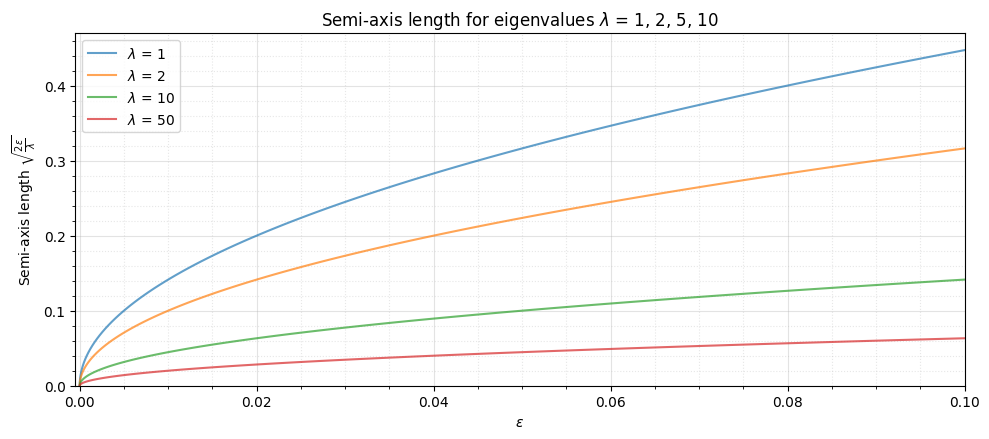

In [ ]:
epsilon_range = 10*(np.linspace(0, 0.1, 101)**2)

fig, ax = plt.subplots(figsize=(10, 4.5), tight_layout=True)
for eigenvalue in [1, 2, 10, 50]:
    ax.plot(epsilon_range, np.sqrt(2*epsilon_range / eigenvalue), label=rf"$\lambda$ = {eigenvalue}", alpha=0.7)
ax.legend()
ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel(r"Semi-axis length $\sqrt{\frac{2\epsilon}{\lambda}}$")
ax.set_title(r"Semi-axis length for eigenvalues $\lambda$ = 1, 2, 5, 10")
ax.set_xlim(-5e-4, np.max(epsilon_range))
ax.set_ylim(0)
ax = set_axis_grid_style(ax)
fig.savefig("confidence_vs_eigenvalue.png", dpi=120, bbox_inches="tight")
plt.show()

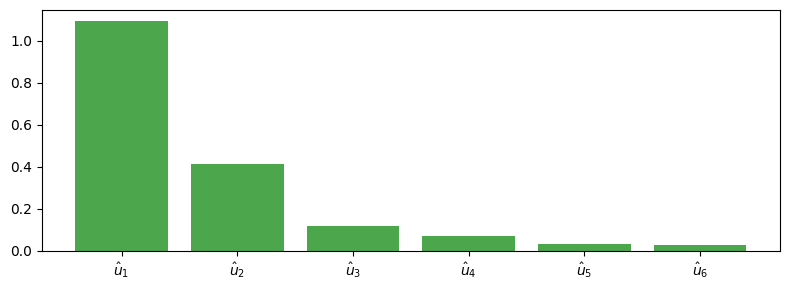

In [ ]:
# Uncertainty plot
fig, ax = plt.subplots(figsize=(8, 3), tight_layout=True)
ax.bar(range(len(eigenvalues)), 1 / np.sqrt(eigenvalues), color="g", alpha=0.7)
ax.set_xticks(range(len(eigenvalues)))
ax.set_xticklabels([r"$\hat{" + "u}_{" + f"{i}" + "}$" for i in range(1, len(design_variables) + 1)])
plt.show()

In [ ]:
def estimate_uncertainty(x_delta, hessian, design_variables):
    """
    Estimate the uncertainty in the parameters based on the Hessian matrix.
    
    Parameters:
        x_delta (array): The change in the parameters.
        hessian (array): The Hessian matrix.
        design_variables (list): The list of design variables.
        
    Returns:
        dict: A dictionary with the estimated uncertainties for each parameter.
    """
    # Calculate the covariance matrix
    covariance_matrix = np.linalg.inv(hessian)
    
    # Calculate the uncertainties
    uncertainties = np.sqrt(np.diag(covariance_matrix))
    
    # Create a dictionary to store the results
    uncertainty_dict = {var: unc for var, unc in zip(design_variables, uncertainties)}
    
    return uncertainty_dict

estimate_uncertainty(None, hessian, design_variables)

{'y_0': np.float64(0.07867346419301191),
 'B_z_0': np.float64(0.41565545747418625),
 'tau': np.float64(0.10193175703907073),
 'C_nm': np.float64(0.353793522109272),
 'delta': np.float64(0.34595559069800197),
 'psi': np.float64(0.9744807286268626)}

In [ ]:
design_variable_labels[-1] = r"$\xi$"

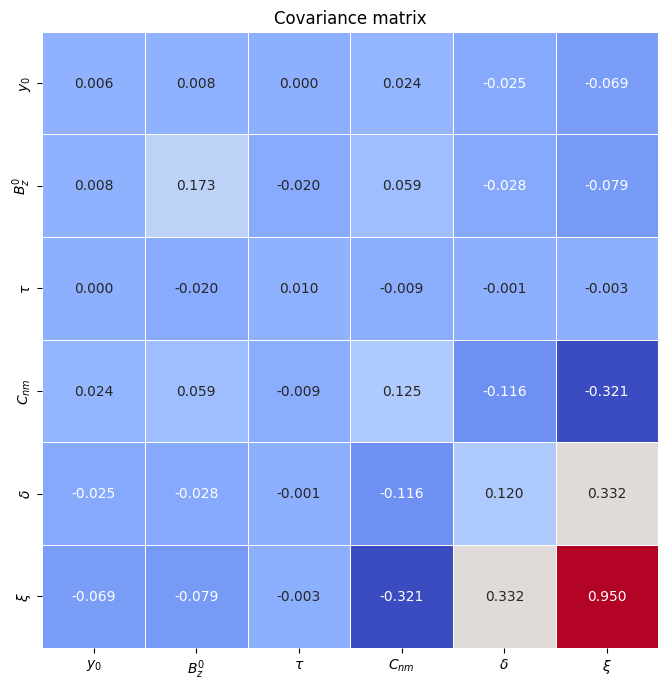

In [ ]:
covariance_matrix = np.linalg.inv(hessian)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(covariance_matrix, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={"shrink": 1.5}, square=True, linewidths=0.5, cbar=False, ax=ax)
ax.set_xticks(np.arange(len(design_variables)) + 0.5)
ax.set_xticklabels(design_variable_labels)
ax.set_yticks(np.arange(len(design_variables)) + 0.5)
ax.set_yticklabels(design_variable_labels)
ax.set_title("Covariance matrix")
fig.savefig("covariance_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

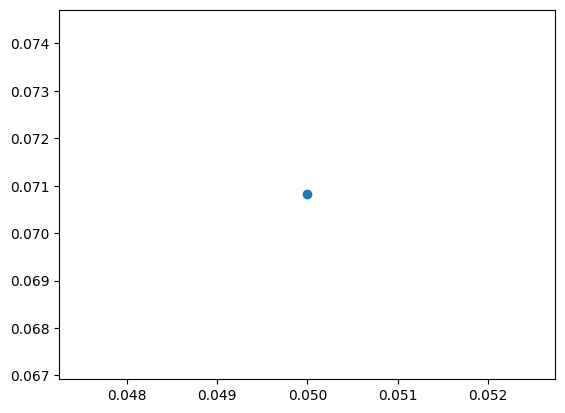

In [ ]:
sigma_range = [result["sigma"] for result in results]
f_opt_range = [result["f_opt"] for result in results]

plt.plot(sigma_range, f_opt_range, "-o")
plt.show()

In [ ]:
# Extract the results
sigma_range = [result["sigma"] for result in results]
param_confidences = {param_name: np.array([result["param_confidences"][param_name] for result in results]) for param_name in all_opt_param_names}
actual_errors = {param_name: np.array([result["actual_errors"][param_name] for result in results]) for param_name in all_opt_param_names}
second_derivatives = {param_name: np.array([result["second_derivatives"][param_name] for result in results]) for param_name in all_opt_param_names}

# Plot the results
num_params = len(results[0]["param_confidences"])
fig, axis = plt.subplots(num_params, 1, figsize=(12, 10), sharex= True, tight_layout=True)
for ax, param_name in zip(axis.flatten(), all_opt_param_names):
    param_label = label_mapping.get(param_name + "_error")
    ax.plot(sigma_range, param_confidences[param_name], label=f"Confidence", marker='o')
    ax.plot(sigma_range, actual_errors[param_name], label=f"Actual error", linestyle='--', marker='x')
    ax.set_ylabel(param_label)
    ax.legend()
    ax = set_axis_grid_style(ax)
    ax.set_xlim(0, np.max(sigma_range))
ax.set_xlabel(r"Gaussian noise level ($\sigma$)")
plt.show()

KeyError: 'param_confidences'

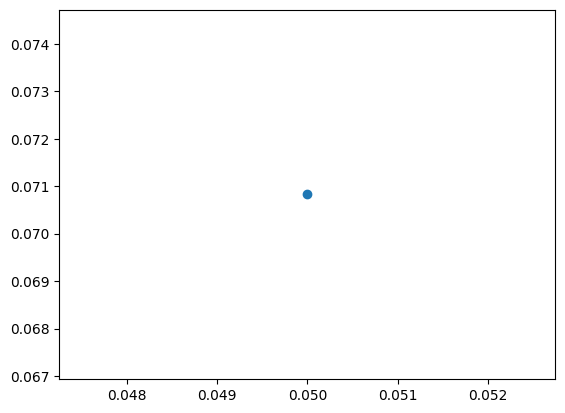

In [ ]:
f_opt = [result["f_opt"] for result in results]

plt.plot(sigma_range, f_opt, label="Fitted Model Error", marker='o')

In [ ]:
np.diff(f_opt) / np.diff(sigma_range)

array([1.50861213, 1.50894631, 1.50926053, 1.50953645])

In [ ]:
for param_name in all_opt_param_names:
    print(param_name, "Ratio", param_confidences[param_name] / actual_errors[param_name])
    print(" ->  Second derivatives", second_derivatives[param_name])

B_z_0 Ratio [402.33852594 397.65896262 354.89985353 311.11601127 276.58160208]
 ->  Second derivatives [59.09065649 18.18945617 10.74408547  7.62164336  5.90436708]
tau Ratio [99.9404902  98.65208994 97.93728937 97.10093899 96.2971823 ]
 ->  Second derivatives [1667.14940618  525.73105515  311.19403173  220.94333816  171.25733518]
C_nm Ratio [1.17584157 1.16577704 1.18602129 1.21507137 1.24850435]
 ->  Second derivatives [1950.56312564  602.73498361  348.50612273  241.92659415  183.56188841]
y_0 Ratio [3.37671743 3.43019559 3.59040299 3.7573172  3.92159449]
 ->  Second derivatives [4318.72997042 1348.12799041  765.94775001  522.79591677  390.59488216]
delta Ratio [0.90679079 0.91261047 0.94405305 0.98019375 1.0179866 ]
 ->  Second derivatives [2882.94240969  869.74365962  488.71944898  331.57288598  247.04024218]
psi Ratio [1.35727134 1.33304215 1.33697193 1.35579405 1.38292671]
 ->  Second derivatives [141.276497    54.87336422  39.10726277  32.39705187  28.60721816]


In [ ]:
param_name = "y_0"
param_confidences[param_name] / actual_errors[param_name]

array([23.20879194, 24.633856  , 26.86480929, 29.3799649 , 32.197517  ])

In [ ]:
ec_model = ECModel(delta=0.8, psi=math.radians(30))

df_noisy = ec_model.simulate_crossing(y_0=0.1, v_sc=450, noise_type="gaussian", epsilon=0.02)

In [ ]:
actual_error_noise = 0.02*ec_model.B_z_0
actual_error_noise

0.2

In [ ]:
model_params = {
    "delta": {"mode": "optimised", "initial_value": 0.8, "bounds": [0.35, 1]},
    "psi": {"mode": "optimised", "initial_value": math.pi/2, "bounds": [1e-3, math.pi - 1e-3]},
    "tau": {"mode": "optimised", "initial_value": 1.4, "bounds": [0.3, 2.0]},
    "C_nm": {"mode": "optimised", "initial_value": 1.4, "bounds": [0.3, 3.0]},
    "B_z_0": {"mode": "optimised", "initial_value": 15.0, "bounds": [5, 15]},
    }

crossing_params = {
    "y_0": {"mode": "optimised", "initial_value": 0.0, "bounds": [-0.65, 0.65]},
    "v_sc": {"mode": "fixed", "value": 450.0},
    "time_stencil": {"mode": "fixed", "value": df_noisy["time"]},
    }

fitted_model, fitted_model_parameters, fitted_crossing_parameters, df_fitted, info = ECModel.fit(ECModel, df_noisy, model_params, crossing_params, residue_method="RMSE")

In [ ]:
info["f_opt"]

0.03197737492725809

In [ ]:
fitted_model.delta

np.float64(0.7976792714341987)

In [ ]:
model_parameters_opt = info["model_parameters_opt"]
crossing_parameters_opt = info["crossing_parameters_opt"]
all_opt_param_names = set(model_parameters_opt.keys()) | set(crossing_parameters_opt.keys())
all_opt_param_names

{'B_z_0', 'C_nm', 'delta', 'psi', 'tau', 'y_0'}

In [ ]:


f_opt = info["f_opt"]
epsilon = 1e-5
second_derivatives = dict()
for param_name in all_opt_param_names:
    second_derivative = perturb_error(ECModel, param_name, df_noisy, fitted_model_parameters, fitted_crossing_parameters, f_opt, epsilon)
    second_derivatives[param_name] = second_derivative
    print(param_name,":", second_derivative)

B_z_0 : 27.799221535840243
tau : 809.9417891926918
C_nm : 952.0756574787902
y_0 : 2200.0363958385446
delta : 1439.139721837179
psi : 63.19220868800101


In [ ]:
param_confidences = dict()
estimated_error = 0.2
for param_name in all_opt_param_names:
    param_confidence = math.sqrt((2*estimated_error) / second_derivatives[param_name])
    param_confidences[param_name] = param_confidence

param_confidences

{'B_z_0': 0.08482008055531706,
 'tau': 0.015714048683092896,
 'C_nm': 0.014493699980064747,
 'y_0': 0.009534547025092537,
 'delta': 0.01178863490182473,
 'psi': 0.056257862894973455}

In [ ]:
# Compute the actual errors in the optimised parameters
actual_errors = dict()
for param_name in all_opt_param_names:
    if param_name in model_parameters_opt:
        actual_errors[param_name] = abs(model_parameters_opt[param_name] - getattr(ec_model, param_name))
    else:
        actual_errors[param_name] = abs(crossing_parameters_opt[param_name] - 0.1)

actual_errors

{'B_z_0': np.float64(0.0038945171021094183),
 'tau': np.float64(0.001469310416487346),
 'C_nm': np.float64(0.0038446812221459847),
 'y_0': np.float64(0.0003682331525900473),
 'delta': np.float64(0.0023207285658013443),
 'psi': np.float64(0.01253176229773989)}